In [237]:
#Instalamos la librerias necesarias (solo la primera vez que ejecutamos el script)
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split

## **1. CARGA Y LIMPIEZA DE DATOS**

In [239]:
df=pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=927&path=AB_NYC_2019.csv")

In [240]:
df.rename(columns={"availability_365": "days_available", "calculated_host_listings_count": "number_adverts"}, inplace=True)
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## 1.1. Columna con valores únicos

In [241]:
#Valores unicos por cada columna
df.nunique()

id                     48895
name                   47905
host_id                37457
host_name              11452
neighbourhood_group        5
neighbourhood            221
latitude               19048
longitude              14718
room_type                  3
price                    674
minimum_nights           109
number_of_reviews        394
last_review             1764
reviews_per_month        937
number_adverts            47
days_available           366
dtype: int64

Podemos observar como no haya variables con un unico valor que no aporten información al futuro modelo predictivo. Aunque vamos a revisar aquellas columnas con un reducido número de valores únicos.

## 1.2. Filas con valores unicos

In [242]:
#Indice
dup_fil=df.duplicated().sum()
print("No hay filas duplicadas" if dup_fil==0 else "Hay filas duplicadas")

No hay filas duplicadas


In [243]:
#Trasponemos las columnas para verificar que toda la fila (variable) no sea igual a otra
dup_col=df.T.duplicated(keep=False).sum()
print("No hay variables exactamente iguales" if dup_col==0 else "Hay variables exactamente iguales")

No hay variables exactamente iguales


## 1.3. Variables redundantes

Identificadores por anfitrión y apartamentos

In [244]:
#Calculamos el numero de valores unicos por hodt_id: si solo hay 1, las variables son redundantes
host_name_por_id = df.groupby('host_id')['host_name'].nunique()
print("host_id con >1 host_name:", (host_name_por_id > 1).sum())

host_id con >1 host_name: 0


[]

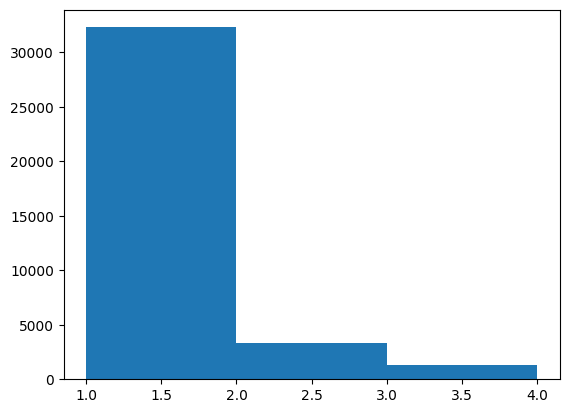

In [245]:
pisos=df["host_id"].value_counts()
plt.hist(pisos[pisos<pisos.quantile(0.99)], bins="auto") #Nº de anuncios por debajo del percentil
plt.plot()

Vamos a crear dos variables: nº alojamientos ofertados y si el individuo ofertante es profesional (n>2)

In [246]:
#Nº Alojamientos
naloj=df['host_id'].map(lambda x: pisos.get(x, 0))
posicion = df.columns.get_loc('host_id')
df.insert(posicion+1, 'lodging', naloj)
df.head(2)

,id,name,host_id,lodging,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,Clean & quiet apt home by the park,2787,6,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,2,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [247]:
#Hoster profesional
prof=df['host_id'].map(lambda x: 1 if pisos.get(x, 0) >= 2 else 0)
posicion = df.columns.get_loc('lodging')
df.insert(posicion+1, 'host_prof', prof)
df.head(2)

,id,name,host_id,lodging,host_prof,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,Clean & quiet apt home by the park,2787,6,1,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,2,1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [248]:
name_por_id = df.groupby('id')['name'].nunique()
print("id con >1 name:", (name_por_id > 1).sum())

id con >1 name: 0


In [249]:
aloj=df["id"].value_counts().sum()
print("No hay alojamientos que aparecen más de una vez" if aloj==df.shape[0] else "Hay alojamientos duplicadas")

No hay alojamientos que aparecen más de una vez


In [251]:
#Eliminamos host name
df.drop(columns=["host_name","name"], axis=1, inplace=True)

## 1.4. Limpieza y Variables categorias

### A) Grupos de barrios

In [252]:
df.groupby("neighbourhood_group")["price"].mean().sort_values().reset_index()

,neighbourhood_group,price
0,Bronx,87.496792
1,Queens,99.517649
2,Staten Island,114.812332
3,Brooklyn,124.383207
4,Manhattan,196.875814


In [253]:
#Creamos un df ordenando lor barrios por su precio medio
orden1=df.groupby("neighbourhood_group")["price"].mean().sort_values().reset_index()#Pasamos la serie a df
#Creamos un ranking de menor a mayor precio
orden1["cat"]=orden1["price"].rank().astype(int)
#Eliminamos el precio del df y establecemos indice para crear el diccionario objetivo
dicc1=orden1.drop(columns=["price"]).set_index("neighbourhood_group").to_dict()["cat"]
dicc1

{'Bronx': 1, 'Queens': 2, 'Staten Island': 3, 'Brooklyn': 4, 'Manhattan': 5}

In [254]:
#Sutituimos los valores en el df
df["neighbourhood_group"]=df["neighbourhood_group"].replace(dicc1).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_1812\2812608512.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["neighbourhood_group"]=df["neighbourhood_group"].replace(dicc1).astype("category")


,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,2787,6,1,4,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,2845,2,1,5,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


### B) Barrios

In [255]:
df.groupby("neighbourhood")["price"].mean().sort_values().reset_index()

,neighbourhood,price
0,Bull's Head,47.333333
1,Hunts Point,50.500000
2,Tremont,51.545455
3,Soundview,53.466667
4,New Dorp,57.000000
...,...,...
216,Riverdale,442.090909
217,Sea Gate,487.857143
218,Tribeca,490.638418
219,Woodrow,700.000000


In [256]:
#Creamos un df ordenando los barrios por su precio medio
orden2=df.groupby("neighbourhood")["price"].mean().sort_values().reset_index()
#Creamos un ranking de menor a mayor precio
orden2["cat"]=orden2["price"].rank().astype(int)
dicc2=orden2.drop(columns=["price"]).set_index("neighbourhood").to_dict()["cat"]
dicc2

{"Bull's Head": 1,
 'Hunts Point': 2,
 'Tremont': 3,
 'Soundview': 4,
 'New Dorp': 5,
 'Bronxdale': 6,
 'New Dorp Beach': 7,
 'Grant City': 8,
 'Concord': 9,
 'Mount Eden': 10,
 'Corona': 11,
 'Woodlawn': 12,
 'Castle Hill': 13,
 'Borough Park': 14,
 'Olinville': 15,
 'Woodhaven': 16,
 'Arden Heights': 17,
 'Emerson Hill': 18,
 'Graniteville': 19,
 'Parkchester': 20,
 'Schuylerville': 21,
 'Morris Park': 22,
 'Fordham': 23,
 'University Heights': 24,
 'Silver Lake': 25,
 'Highbridge': 26,
 'Westerleigh': 27,
 'Concourse Village': 28,
 'Rossville': 29,
 'Fieldston': 30,
 'Little Neck': 31,
 'Baychester': 32,
 'Norwood': 33,
 'Bensonhurst': 34,
 'New Springville': 35,
 'Tompkinsville': 36,
 'Brownsville': 37,
 'Rosedale': 38,
 'Morris Heights': 39,
 'Belmont': 40,
 'Ridgewood': 41,
 'Co-op City': 42,
 'Mount Hope': 42,
 'Kingsbridge': 44,
 'Richmondtown': 45,
 'Gravesend': 46,
 'Dongan Hills': 47,
 'Port Morris': 48,
 'North Riverdale': 49,
 'Midwood': 50,
 'Elmhurst': 51,
 'West Brighto

In [257]:
#Sutituimos los valores en el df
df["neighbourhood"]=df["neighbourhood"].replace(dicc2).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_1812\1461765114.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["neighbourhood"]=df["neighbourhood"].replace(dicc2).astype("category")


,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,2787,6,1,4,93,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,2845,2,1,5,210,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


### C) Tipo de habitación

In [258]:
df.groupby("room_type")["price"].mean().sort_values().reset_index()

,room_type,price
0,Shared room,70.127586
1,Private room,89.780973
2,Entire home/apt,211.794246


In [259]:
#Creamos un df ordenando los barrios por su precio medio
orden3=df.groupby("room_type")["price"].mean().sort_values().reset_index()
#Creamos un ranking de menor a mayor precio
orden3["cat"]=orden3["price"].rank().astype(int)
dicc3=orden3.drop(columns=["price"]).set_index("room_type").to_dict()["cat"]
dicc3

{'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}

In [260]:
#Sutituimos los valores en el df
df["room_type"]=df["room_type"].replace(dicc3).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_1812\3597542359.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["room_type"]=df["room_type"].replace(dicc3).astype("category")


,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available
0,2539,2787,6,1,4,93,40.64749,-73.97237,2,149,1,9,2018-10-19,0.21,6,365
1,2595,2845,2,1,5,210,40.75362,-73.98377,3,225,1,45,2019-05-21,0.38,2,355


### D) Dias desde la ultima reseña

In [261]:
df["last_review"].sort_values().unique()

array(['2011-03-28', '2011-04-25', '2011-05-12', ..., '2019-07-07',
       '2019-07-08', nan], shape=(1765,), dtype=object)

In [262]:
# Pasamos la columna a datetime para poder trabajar con ella 
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') #errors --> maneja valores no YY/MM/dd
# Creamos la fecha de la utima reseña posible
## Establecemos como ultima fecha 2 dias de margen sobre la fecha mas cercana
today = df['last_review'].sort_values(ascending=False).iloc[0]+ pd.Timedelta(days=2)
df['days_since_review'] = (today - df['last_review']).dt.days
df.head(2)

,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available,days_since_review
0,2539,2787,6,1,4,93,40.64749,-73.97237,2,149,1,9,2018-10-19,0.21,6,365,264.0
1,2595,2845,2,1,5,210,40.75362,-73.98377,3,225,1,45,2019-05-21,0.38,2,355,50.0


In [263]:
df[df["last_review"].isna()].head(2)

,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available,days_since_review
2,3647,4632,1,0,5,137,40.80902,-73.94190,2,150,3,0,NaT,NaN,1,365,NaN
19,7750,17985,2,1,5,149,40.79685,-73.94872,3,190,7,0,NaT,NaN,2,249,NaN


### E) Reseñas al mes

In [264]:
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'], errors='coerce')
df['reviews_per_month'].fillna(0, inplace=True)
df[df['reviews_per_month'].isna()]

C:\Users\jjime\AppData\Local\Temp\ipykernel_1812\3695158955.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)


,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available,days_since_review


## 1.5. Valores faltantes

In [265]:
df.isna().mean()*100

id                      0.000000
host_id                 0.000000
lodging                 0.000000
host_prof               0.000000
neighbourhood_group     0.000000
neighbourhood           0.000000
latitude                0.000000
longitude               0.000000
room_type               0.000000
price                   0.000000
minimum_nights          0.000000
number_of_reviews       0.000000
last_review            20.558339
reviews_per_month       0.000000
number_adverts          0.000000
days_available          0.000000
days_since_review      20.558339
dtype: float64

<Axes: >

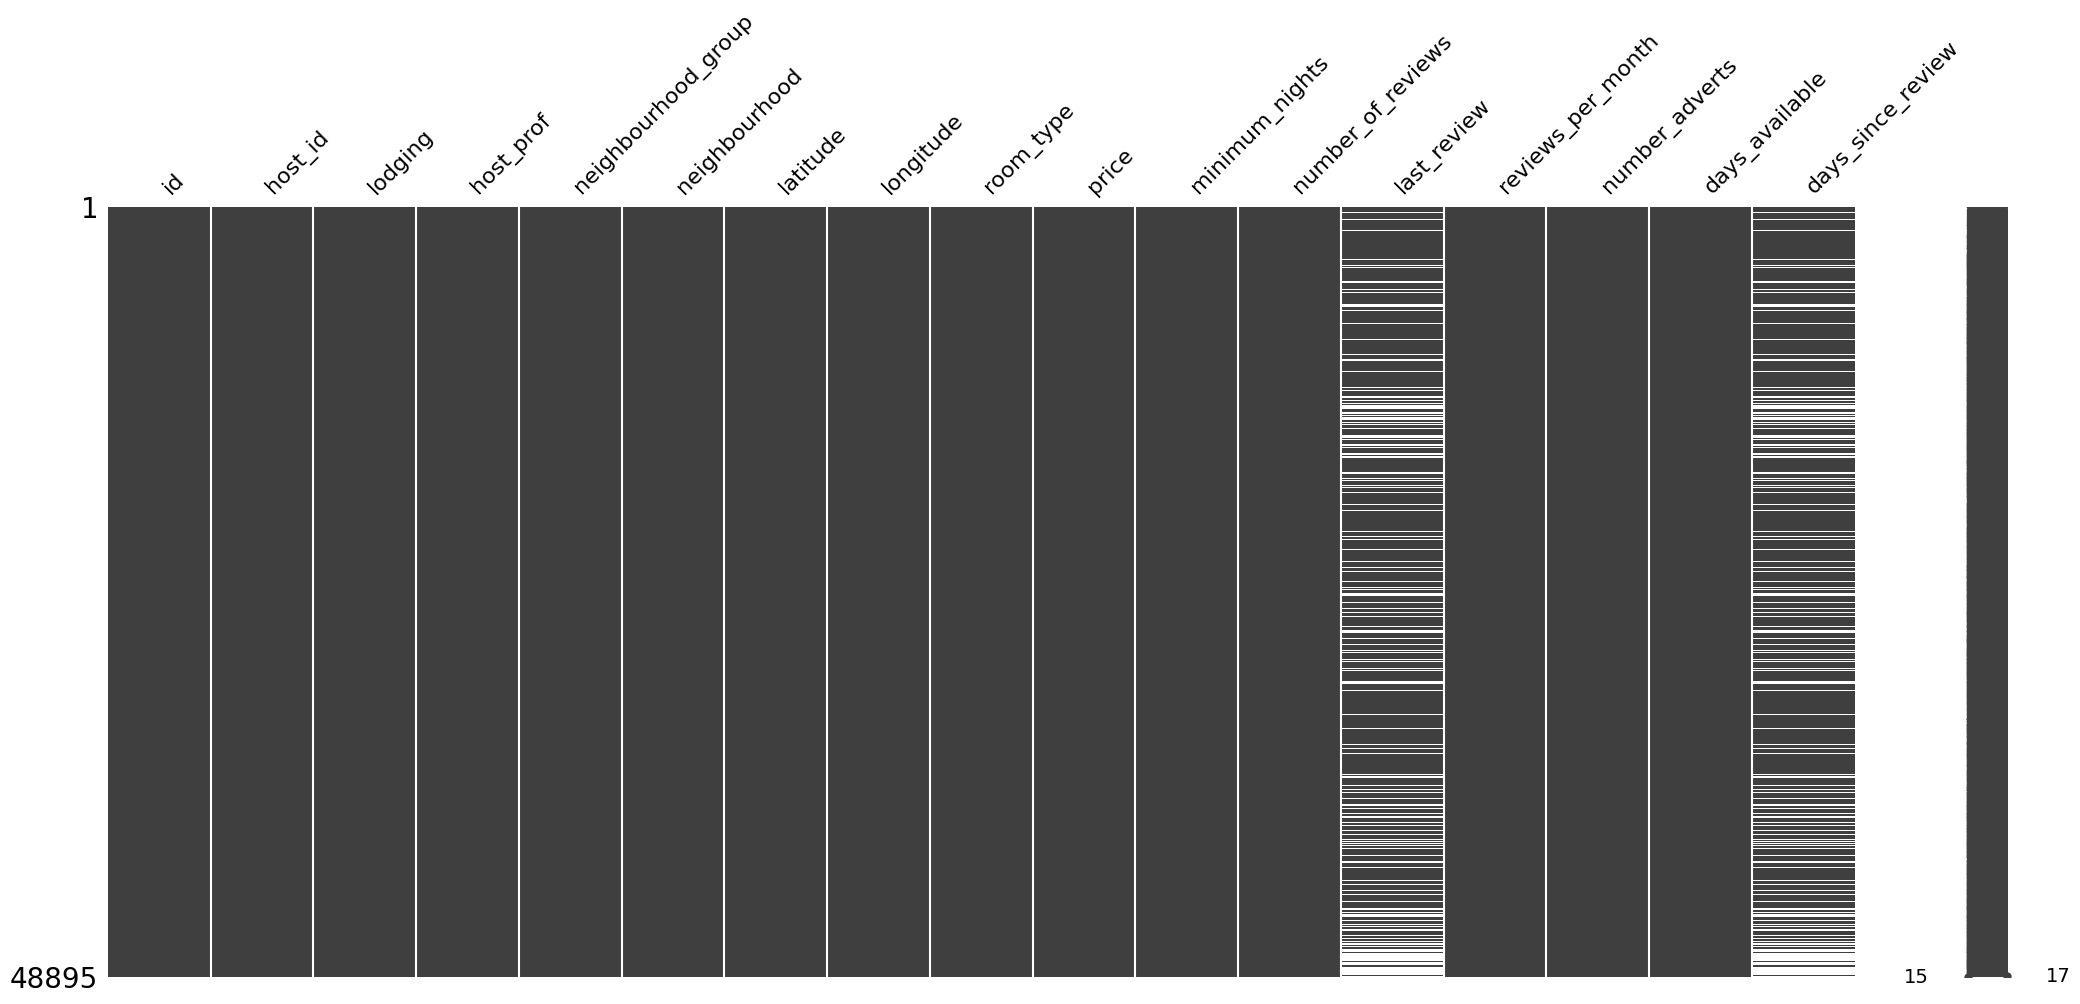

In [266]:
msno.matrix(df)

## 1.6. División train-test

In [267]:
X=df.drop("price", axis=1)
y=df["price"]

In [268]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42) #random_state establece una semilla para que la division aleatoria sea la misma

# 2. MANIPULACION DE VALORES EXTRAÑOS

## 2.1. Missing values

## 2.2. Outliers

In [270]:
X_train.head(2)

,id,host_id,lodging,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,number_adverts,days_available,days_since_review
32645,25674366,9038810,1,0,4,158,40.71577,-73.95530,3,3,11,2019-05-16,0.87,1,1,55.0
23615,19100971,81745867,1,0,5,86,40.84917,-73.94048,2,2,2,2018-06-25,0.16,1,0,380.0


In [273]:
columns=["lodging", "host_prof", "neighbourhood_group", "neighbourhood", "latitude", "longitude", "room_type", "minimum_nights", "number_of_reviews", "reviews_per_month", "days_since_review", "days_available"]
X_train[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lodging,39116.0,7.188925,33.172629,1.00000,1.000000,1.000000,2.000000,327.00000
host_prof,39116.0,0.339554,0.473564,0.00000,0.000000,0.000000,1.000000,1.00000
latitude,39116.0,40.728927,0.054555,40.49979,40.690067,40.723035,40.763180,40.91306
longitude,39116.0,-73.952311,0.046029,-74.24285,-73.983080,-73.955750,-73.936498,-73.71299
minimum_nights,39116.0,7.144775,21.472973,1.00000,1.000000,3.000000,5.000000,1250.00000
number_of_reviews,39116.0,23.334978,44.499352,0.00000,1.000000,5.000000,24.000000,629.00000
reviews_per_month,39116.0,1.094376,1.604249,0.00000,0.040000,0.370000,1.590000,58.50000
days_since_review,31010.0,277.330087,413.495354,2.00000,17.000000,51.000000,360.000000,2998.00000
days_available,39116.0,113.445368,131.846430,0.00000,0.000000,46.000000,229.000000,365.00000


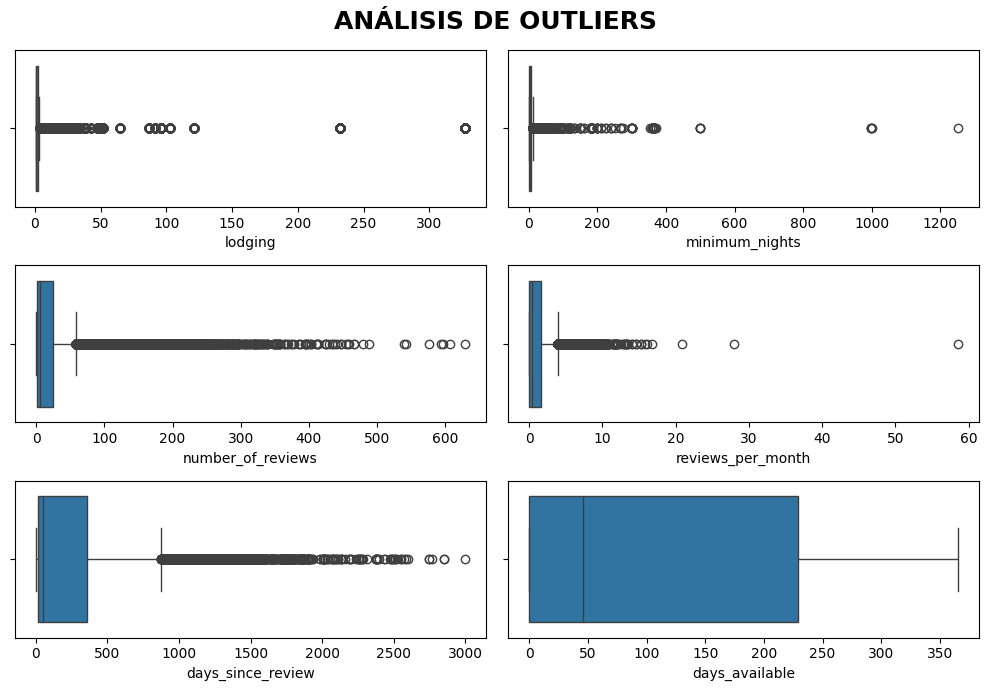

In [301]:
#4*3
fig, axis = plt.subplots(3, 2, figsize = (10, 7))

# Crear una figura múltiple con histogramas y diagramas de caja
sns.boxplot(ax = axis[0, 0], data = X_train, x = "lodging")
sns.boxplot(ax = axis[0, 1],data = X_train, x = "minimum_nights")
sns.boxplot(ax = axis[1, 0],data = X_train, x = "number_of_reviews")
sns.boxplot(ax = axis[1, 1],data = X_train, x = "reviews_per_month")
sns.boxplot(ax = axis[2, 0],data = X_train, x = "days_since_review")
sns.boxplot(ax = axis[2, 1],data = X_train, x = "days_available")
fig.suptitle("Análisis de Outliers".upper(), size=18, fontweight="bold")
# Ajustar el layout
plt.tight_layout()
# Mostrar el plot
plt.show()

## 2.3. Selección de carcaterísticas

### A) Feature Importance

### B) VIF 